## 0. Import Libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from xclim import sdba

import xclim

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Exercises (Redundant)

https://xclim.readthedocs.io/en/stable/notebooks/sdba.html

In [2]:
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")

In [3]:
vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals / 100, vals)) / 3e6
vals_sim = (
    (1 + 0.1 * np.random.random_sample((t.size,)))
    * (4 ** np.where(vals < 9.5, vals / 100, vals))
    / 3e6
)

pr_ref = xr.DataArray(
    vals_ref, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_ref = pr_ref.sel(time=slice("2000", "2015"))
pr_sim = xr.DataArray(
    vals_sim, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_hist = pr_sim.sel(time=slice("2000", "2015"))

In [4]:
pr_hist

<xarray.DataArray (time: 5840)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.91664883e-07, 3.50336049e-07, 3.85657170e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    units:    mm/day

In [5]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm/day

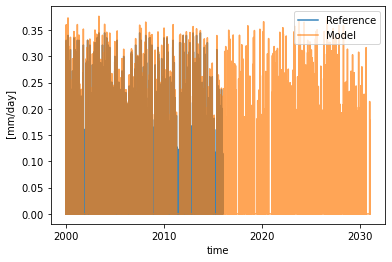

In [6]:
pr_ref.plot(alpha=0.9, label="Reference")
pr_sim.plot(alpha=0.7, label="Model")
plt.legend()

In [7]:
QM = sdba.EmpiricalQuantileMapping.train(pr_ref, pr_hist, nquantiles=15, kind="*", group="time")

In [8]:
scen = QM.adjust(pr_sim)

In [10]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm d-1

In [18]:
scen_single = QM.adjust(pr_sim[-100:])

In [22]:
QM.ds.af

<xarray.DataArray 'af' (group: 1, quantiles: 15)>
array([[9.75031131e-01, 9.62698858e-01, 9.57974063e-01, 9.55625349e-01,
        9.53690951e-01, 9.54751877e-01, 9.54133927e-01, 9.52794039e-01,
        9.52409635e-01, 9.52008611e-01, 9.50360988e-01, 9.48842627e-01,
        9.44231995e-01, 2.16432385e+04, 9.56025534e-01]])
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Attributes:
    units:          mm d-1
    kind:           *
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

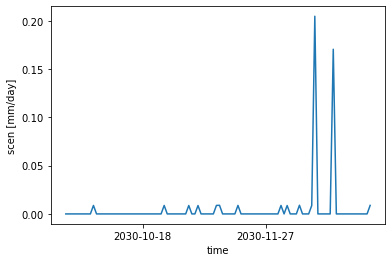

In [19]:
scen_single.plot()

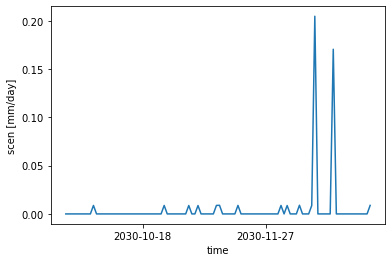

In [20]:
scen[-100:].plot()

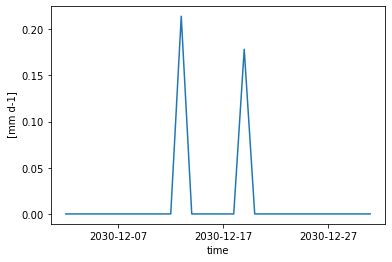

In [14]:
pr_sim[-30:].plot()

In [18]:
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 15, group: 1)
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Data variables:
    af         (group, quantiles) float64 0.9748 0.965 ... 2.196e+05 0.9546
    hist_q     (group, quantiles) float64 3.436e-07 3.505e-07 ... 0.2297
Attributes:
    group:               time
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(name='time'),...

## 1. Open Data

In [3]:
path_general = r'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'
season = 'JJA' # DJF or JJA

#### 1.1.1 Model

In [4]:
dt_model = xr.open_dataset(fr'{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_1hr_masked_198501_200512.nc',
                     chunks={"rlon": 20, "rlat":20}
                          )

#### 1.1.2 ERA5

In [5]:
dt_era5 = xr.open_dataset(fr'{path_general}/era5land/era5land_TOT_PREC_{season}_1hr_regrid_masked_1985_2005.nc',
                     chunks={"rlon": 20, "rlat":20}, #decode_cf=False
                         )

#data.where(data!=nodata, np.nan)
# alttakileri aç decode cf olursa
#dt_era5['tp'] = dt_era5['tp'].where(dt_era5['tp'] != dt_era5['tp'].attrs['missing_value'], 
#                                    np.nan)
#dt_era5['tp'] = (dt_era5['tp'] * dt_era5['tp'].attrs['scale_factor'] + dt_era5['tp'].attrs['add_offset'])
dt_era5['tp'] = dt_era5['tp'] * 1e3 # m to mm
#dt_era5['time'] = dt_model['time']
dt_era5['tp'].attrs['units'] = 'mm'

In [6]:
dt_era5

<xarray.Dataset>
Dimensions:      (time: 46368, rlat: 59, rlon: 137)
Coordinates:
  * time         (time) datetime64[ns] 1985-06-01 ... 2005-08-31T23:00:00
  * rlon         (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat         (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    lon          (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    lat          (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    year         int64 ...
    spatial_ref  int64 ...
Data variables:
    tp           (time, rlat, rlon) float32 dask.array<chunksize=(46368, 20, 20), meta=np.ndarray>

## 2. Pre-process Zero Values

In [7]:
wet_hour_mm = 0.1

# adjust era5
dt_era5['tp'] = dt_era5['tp'].where(dt_era5['tp']>wet_hour_mm, 
                                    0.05
                                   )

# adjust model
dt_model['TOT_PREC'] = dt_model['TOT_PREC'].where(dt_model['TOT_PREC']>wet_hour_mm, 
                                    0.05
                                   )

## 3. Create Bias Correction Coefficients

### 3.1 Train Quantile Mapping

QM = sdba.EmpiricalQuantileMapping.train(dt_era5['tp'], 
                                         dt_model['TOT_PREC'], 
                                         nquantiles=15, 
                                         kind="*", 
                                         group="time")

In [8]:
quantiles = np.array([0.033333, 0.1     , 0.166667, 0.233333, 0.3     , 0.366667, 0.433333,
       0.5     , 0.566667, 0.633333, 0.7     , 0.766667, 0.833333, 0.9     ,
       0.966667, 1])

QM = sdba.QuantileDeltaMapping.train(dt_era5['tp'], 
                                         dt_model['TOT_PREC'], 
                                         nquantiles=quantiles, 
                                         kind="*", 
                                         group="time")

### 3.2 Save Coefficient Data

In [9]:
bias_algo = 'QDM_era5land' # EQM or QDM
from dask.diagnostics import ProgressBar

delayed_obj = QM.ds.to_netcdf(fr"/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/data/bias_correction/{bias_algo}_coefficients_{season}.nc", compute=False)

with ProgressBar():
    results = delayed_obj.compute()

[########################################] | 100% Completed | 23min 52.1s


In [10]:
# check coeff data
bias_algo = 'QDM_era5land' # EQM or QDM
ll = xr.open_dataset(fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/data/bias_correction/{bias_algo}_coefficients_{season}.nc')

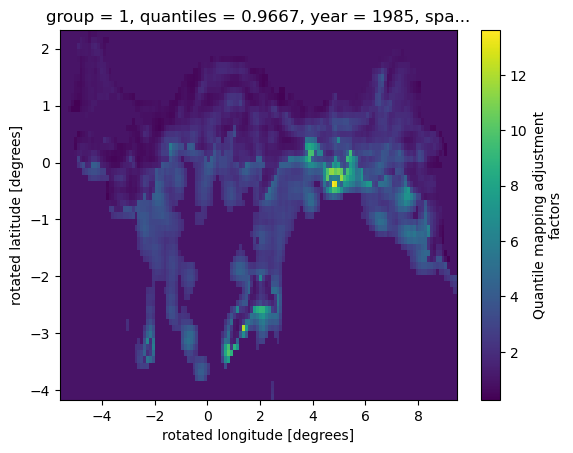

In [19]:
ll['af'].squeeze()[:,:,-2].plot()